# Artificial Neural Network from Scratch

Developed by:
| Nama | NIM |
| ---- | --- |
| Henry Anand Septian Radityo | 13521004 |
| Matthew Mahendra | 13521007 |
| Hidayatullah Wildan Ghaly Buchary | 13521015 |
| Ahmad Nadil | 13521024 |

# Dependencies

In [1]:
import numpy as np
import json
import matplotlib.pyplot as plt
import networkx as nx
import joblib
import time
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras import Input
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report

# Iris Dataset

In [2]:
df = pd.read_csv('./data/iris.csv')
df

,Id,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm,Species
0,1,5.1,3.5,1.4,0.2,Iris-setosa
1,2,4.9,3.0,1.4,0.2,Iris-setosa
2,3,4.7,3.2,1.3,0.2,Iris-setosa
3,4,4.6,3.1,1.5,0.2,Iris-setosa
4,5,5.0,3.6,1.4,0.2,Iris-setosa
...,...,...,...,...,...,...
145,146,6.7,3.0,5.2,2.3,Iris-virginica
146,147,6.3,2.5,5.0,1.9,Iris-virginica
147,148,6.5,3.0,5.2,2.0,Iris-virginica
148,149,6.2,3.4,5.4,2.3,Iris-virginica


In [3]:
le = LabelEncoder()
df["Species"] = le.fit_transform(df["Species"])
df["Species"]

0      0
1      0
2      0
3      0
4      0
      ..
145    2
146    2
147    2
148    2
149    2
Name: Species, Length: 150, dtype: int32

In [4]:
data = df.drop(columns=["Id", "Species"])
# Encode Target with One Hot Encoder
target = np.zeros((df["Species"].size, df["Species"].max() + 1))
target[np.arange(df["Species"].size), df["Species"]] = 1

# Split Train and Test data
X_train, X_test, y_train, y_test = train_test_split(
    data, target, test_size=0.2, random_state=42
)

# Layer Class

In [5]:
class Layer:
    """
    Layer class with different methods of activation

    Attributes
    ----------
    activation: str
        The activation type. Must be either 'linear', 'sigmoid', 'relu', or 'softmax'

    neuron: int
        Number of neurons on the layer. Must at least be 1

    weights: np.array
        Weights of each neuron corresponding to the previous layers

    bias: np.array
        Bias of each neuron. Element of array must match the number of neurons available
    """

    LINEAR = "linear"
    SIGMOID = "sigmoid"
    RELU = "relu"
    SOFTMAX = "softmax"

    def __init__(self, activation: str, neuron: int, weights: np.array, bias: np.array):
        """
        Class constructor

        Parameters
        ----------
        activation: str
        The activation type. Must be either 'linear', 'sigmoid', 'relu', or 'softmax'

        neuron: int
            Number of neurons on the layer. Must at least be 1

        weights: np.array
            Weights of each neuron corresponding to the previous layers

        bias: np.array
            Bias of each neuron. Element of array must match the number of neurons available
        """
        self.activation = activation
        self.neuron = neuron

        self.weights = weights
        self.deltaWeights = np.copy(weights)
        self.deltaWeights[:] = 0

        self.bias = bias
        self.deltaBias = np.copy(bias)
        self.deltaBias[:] = 0

        self.net = None
        self.input = None

    def __str__(self):
        return f"Activation Function: {self.activation}; Neuron: {self.neuron}; weights: {np.array_str(self.weights)}; bias: {np.array_str(self.bias)}"

    def linear(self, x):
        """
        Linear activation function

        Parameters
        ----------
        x: np.array
            Array of inputs

        Returns
        -------
        x: np.array
            Activated inputs
        """
        return x

    def relu(self, x):
        """
        ReLU activation function

        Parameters
        ----------
        x: np.array
            Array of inputs

        Returns
        -------
        x: np.array
            Activated inputs
        """
        return np.maximum(0, x)

    def sigmoid(self, x):
        """
        Sigmoid activation function

        Parameters
        ----------
        x: np.array
            Array of inputs

        Returns
        -------
        x: np.array
            Activated inputs
        """
        return 1 / (1 + np.exp(-x))

    def softmax(self, x):
        """
        Softmax activation function

        Parameters
        ----------
        x: np.array
            Array of inputs

        Returns
        -------
        x: np.array
            Activated inputs
        """
        exp = np.exp(x - np.max(x))
        exps = np.sum(exp)
        return exp / exps

    def calculate(self, x):
        """
        Calculation of each input with the corresponding activation method

        Parameters
        ----------
        x: np.array
            Array of inputs

        Returns
        -------
        x: np.array
            Activated inputs
        """
        if self.activation == Layer.LINEAR:
            return self.linear(x)
        elif self.activation == Layer.SIGMOID:
            return self.sigmoid(x)
        elif self.activation == Layer.RELU:
            return self.relu(x)
        elif self.activation == Layer.SOFTMAX:
            return self.softmax(x)

    def derivative(self, x):
        """
        Derivative of activation methods

        Parameters
        ----------
        x: np.array
            Array of inputs

        Returns
        -------
        x: np.array
            Derivated inputs
        """
        if self.activation == Layer.LINEAR:
            return np.ones_like(x)
        elif self.activation == Layer.SIGMOID:
            return self.sigmoid(x) * (1 - self.sigmoid(x))
        elif self.activation == Layer.RELU:
            return np.where(x <= 0, 0, 1)
        elif self.activation == Layer.SOFTMAX:
            s = self.softmax(x)
            return np.diagflat(s) - np.outer(s, s)
    
    def forward(self, input: np.array):
        """
        Forward API for the neural network class

        Parameters
        ----------
        input: np.array
            Array of inputs

        Returns
        -------
        x: np.array
            Calculated and activated inputs of net
        """
        self.input = input
        self.net = np.dot(input, self.weights) + self.bias
        return self.calculate(self.net)

    def update_weight(self, delta, learning_rate, input_idx, final):
        """
        Update weight of each data input_idx

        Parameters
        ----------
        delta: np.array
            Calculated error term

        learning_rate: float
            Learning Rate

        input_idx: int
            Input id, corresponds to which data is going to be updated

        final: boolean
            If it's the final data in the batch
        """

        for i, deltaWeight in enumerate(np.transpose(self.deltaWeights)):
            # Update deltaWeight
            gradient = delta[i] * learning_rate * -1 * self.input[input_idx]
            deltaWeight += gradient

            # Update deltaBias
            self.deltaBias[i] += delta[i] * learning_rate * -1

        if final:
            self.weights += self.deltaWeights
            self.bias += self.deltaBias

            # Reset deltaWeights and deltaBias
            self.deltaWeights[:] = 0
            self.deltaBias[:] = 0

# ANN Class

In [6]:
class ANN:
    """
    An implementation of Artifical Neural Network with Forward Propagation and Back Propagation

    Attributes
    ----------
    layer: list[Layer]
        The layers of the neural network

    results: np.array
        The results of the final output layer
    """

    def __init__(self, layers: list[Layer] = None):
        """
        Class Constructor

        Parameters
        ----------
        layer: list[Layer]
            The layers of the neural network
        """
        self.layers = layers
        self.results = None
        self.input = None
        self.target = None
        self.filename = None
        self.stoppedBy = None

    def load_model(self, filename: str):
        """
        Function to load a model given a filename

        Parameters
        ----------
        filename: str
            Filename of the json file. Must be located in a models path relative to this file
        """
        try:
            self.filename = filename
            file = open(f"models_ann/{filename}.json", "r")
            model = json.load(file)
            file.close()
            json_layer = model["case"]["model"]["layers"]
            json_weights = model["case"]["initial_weights"]
            json_input = model["case"]["input"]
            json_target = model["case"]["target"]
            json_learning_parameters = model["case"]["learning_parameters"]
            json_stopped_by = model["expect"]["stopped_by"]
            json_final_weights = model["expect"]["final_weights"]
            layers = []
            # Create the layers from the layer
            for i in range(len(json_layer)):
                layer = Layer(
                    activation=json_layer[i]["activation_function"],
                    neuron=json_layer[i]["number_of_neurons"],
                    weights=np.array(json_weights[i][1:]),
                    bias=np.array(json_weights[i][0]),
                )
                layers.append(layer)

            self.layers = layers
            self.input = np.array(json_input)
            self.target = np.array(json_target)
            self.learning_parameters = json_learning_parameters
            self.stopped_by = json_stopped_by
            self.final_weights = json_final_weights

        except FileNotFoundError:
            print("Model not found")
            exit()

    def save_model(self, filename: str):
        """
        Function to output a model to file

        Parameters
        ----------
        filename: str
            Model filename save
        """
        joblib.dump(self, f"res/{filename}.joblib")

    def fit(self, input: np.array, target: np.array):
        """
        Fit the inputs. Sklearn API

        Parameters
        ----------
        input: np.array
            Data of the models

        target: np.array
            Actual values to be predicted
        """
        self.input = input
        self.target = target

    def add_layer(self, layer: Layer):
        """
        Function to add layers to the neural network

        Parameters
        ----------
        layer: Layer
            The layer to be added

        Returns
        -------
        None
        """
        self.layers.append(layer)

    def forward(self, input):
        """
        Function to forward the inputs

        Parameters
        ----------
        None

        Returns
        -------
        results: np.array
            Output of the final output layer
        """
        self.results = input
        for layer in self.layers:
            self.results = layer.forward(self.results)
        return self.results

    def train(
        self,
        epoch: int = 1,
        learning_rate: float = 0.5,
        batch_size: int = 32,
        error_threshold: float = 0.01,
    ):
        """
        Train function

        Parameters
        ----------
        epoch: int
            Number of iterations

        learning_rate: float
            Learning rate value

        batch_size: int
            Number of batches to update

        error_threshold: float
            Maximum error before stopping training

        Returns
        -------
        None
        """
        n_samples = self.input.shape[0]
        indices = np.arange(n_samples)

        self.stoppedBy = "max_iteration"

        for e in range(epoch):
            current_loss = 0
            count = 0
            start_time = time.time()
            for start_idx in range(0, n_samples, batch_size):
                end_idx = min(start_idx + batch_size, n_samples)
                batch_indices = indices[start_idx:end_idx]
                batch_input = self.input[batch_indices]
                batch_target = self.target[batch_indices]

                self.forward(batch_input)

                batch_loss = 0
                if self.layers[len(self.layers) - 1].activation != "softmax":
                    batch_loss = 0.5 * np.sum((self.results - batch_target) ** 2)
                else:
                    batch_loss = -np.sum(batch_target*np.log(self.results)) / len(self.results)
                current_loss += batch_loss
                count+=1

                # Steps
                for i, result in enumerate(self.results):
                    deltas = []
                    delta = None
                    previous_layer = None

                    # Back Propagation
                    for j, layer in enumerate(reversed(self.layers)):
                        if j == 0:
                            # Output Layer
                            if layer.activation == "softmax":
                                # dE/dw = dE/dnet * dnet/dw
                                delta = self.results[i] - batch_target[i]
                            else:
                                delta = (
                                    layer.derivative(layer.net[i])
                                    * (batch_target[i] - self.results[i])
                                    * -1
                                )
                        else:
                            # Hidden Layer
                            delta = layer.derivative(layer.net[i]) * np.sum(
                                deltas[-1] * previous_layer.weights, axis=1
                            )

                        deltas.append(delta)
                        previous_layer = layer
                    
                    # Mini Batch Update
                    for j, layer in enumerate(reversed(self.layers)):
                        if (i + 1) == batch_size or (
                            i == (len(self.results) - 1) and end_idx == n_samples
                        ):
                            # Do the batch update
                            layer.update_weight(deltas[j], learning_rate, i, True)
                        else:
                            # Update delta weight
                            layer.update_weight(deltas[j], learning_rate, i, False)

            # Early stop using threshold
            current_loss/=count
            finish_time = time.time()
            print(
                f"EPOCH {e+1}/{epoch}\t|\tLoss: {round(current_loss,4)}\t|\tTime: {round(1000 * (finish_time - start_time), 4)} ms"
            )
            if current_loss <= error_threshold:
                self.stoppedBy = "error_threshold"
                print(f"Training Stopped on epoch {e+1}")
                break

    def predict(self, X: np.array):
        """
        Predict function. Sklearn API

        Parameters
        ----------
        X: np.array
            X is the data to be predicted

        Returns
        -------
        results: np.array
            Predicted class of the input X
        """
        self.forward(X)
        return np.argmax(self.results, axis=1)

    def summarize(self, verbose: int = 1):
        """
        Function to summarize the model's layers

        Parameters
        ----------
        verbose: int
            Verbose of information. 1 for text, 2 for visualization

        Returns
        -------
        None
        """

        if verbose == 1:
            print("Model Network")
            for i, layer in enumerate(self.layers):
                print(f"{i+1}. {layer}")
        elif verbose == 2:
            # graph = Graph(self)
            # graph.draw_neural_net()
            total_nodes = sum([len(layer.weights) for layer in self.layers]) + len(
                self.results
            )
            fig_width = max(12, total_nodes / 3)
            fig_height = max(6, total_nodes / 6)

            fig, ax = plt.subplots(figsize=(fig_width, fig_height))

            layer_sizes = []
            for layer in self.layers:
                layer_sizes.append(len(layer.weights))
            layer_sizes.append(len(self.layers[len(self.layers) - 1].weights[0]))

            weights = []
            biases = []

            for layer in self.layers:
                weights.append(layer.weights)
                biases.append(layer.bias)

            n_layers = len(layer_sizes)
            v_spacing = (1.0 / max(layer_sizes)) * 0.8
            h_spacing = 1.0 / (n_layers - 1)
            node_size = 2000
            input_color = "gold"
            hidden_color = "gray"
            output_color = "salmon"
            bias_color = "lightgreen"
            edge_color = "black"
            layers = []
            proporsi = 0.75

            G = nx.DiGraph()
            node_colors = {}

            for i in range(n_layers):
                layer = []
                if i < n_layers - 1:
                    layer.append("b" + str(i))
                for j in range(layer_sizes[i]):
                    if i == 0:
                        layer.append("x" + str(j + 1))
                    elif i < n_layers - 1:
                        layer.append("h" + str(i) + str(j + 1))
                    else:
                        layer.append("o" + str(j))
                layers.append(layer)

            for i in range(n_layers):
                for j in range(len(layers[i])):
                    if "x" in layers[i][j]:
                        node_color = input_color
                    elif "h" in layers[i][j]:
                        node_color = hidden_color
                    elif "o" in layers[i][j]:
                        node_color = output_color
                    elif "b" in layers[i][j]:
                        node_color = bias_color

                    G.add_node(
                        layers[i][j],
                        pos=(h_spacing * i, v_spacing * (len(layers[i]) - j) - 0.1),
                    )
                    node_colors[layers[i][j]] = node_color

            for i in range(n_layers - 1):
                for j in range(len(layers[i])):
                    target_start_index = 1 if i + 1 < n_layers - 1 else 0
                    for k in range(target_start_index, len(layers[i + 1])):
                        G.add_edge(layers[i][j], layers[i + 1][k], color=edge_color)
                        x = [
                            G.nodes[layers[i][j]]["pos"][0],
                            G.nodes[layers[i + 1][k]]["pos"][0],
                        ]
                        y = [
                            G.nodes[layers[i][j]]["pos"][1],
                            G.nodes[layers[i + 1][k]]["pos"][1],
                        ]

                        label_x = (proporsi * x[0]) + ((1 - proporsi) * x[1])
                        label_y = (proporsi * y[0]) + ((1 - proporsi) * y[1])

                        if j == 0:
                            weight_label = (
                                biases[i][k - 1] if i < n_layers - 2 else biases[i][k]
                            )
                            ax.text(
                                label_x,
                                label_y,
                                str(weight_label),
                                color="red",
                                ha="center",
                                va="center",
                            )
                        else:
                            weight_label = (
                                weights[i][max(j - 1, 0)][k - target_start_index]
                                if j > 0
                                else str(weights[i][j][k - 1])
                            )
                            ax.text(
                                label_x,
                                label_y,
                                str(weight_label),
                                color="red",
                                ha="center",
                                va="center",
                            )

            pos = nx.get_node_attributes(G, "pos")
            edges = G.edges()
            colors = [G[u][v]["color"] for u, v in edges]

            nx.draw(
                G,
                pos,
                ax=ax,
                node_size=node_size,
                node_color=[node_colors[node] for node in G.nodes()],
                edge_color=colors,
                with_labels=True,
                font_size=8,
            )

    def sse(self, filename: str = None):
        """
        Sum Squared Error method to determine if a test case succeeds or not

        Parameters
        ----------
        filename: str
            Name of the file to be used as a testcase

        Returns
        -------
        verdict: bool
            Verdict of the testcase
        """

        sse_max = np.exp(-7)

        sse = 0
        for layer, output in zip(self.layers, self.final_weights):
            l = np.append(layer.bias, layer.weights).reshape(
                len(layer.weights) + 1, len(layer.bias)
            )
            sse += np.sum((output - l) ** 2)

        sse = sse / len(self.layers)

        print(f"SSE: {sse}")
        return sse <= sse_max and self.stoppedBy == self.stopped_by

# Test Cases

Untuk semua kasus uji, semua stop condition dan SSE dapat diterima dalam rentang error yang diberikan

EPOCH 1/200	|	Loss: 0.7442	|	Time: 2.0044 ms
EPOCH 2/200	|	Loss: 0.7193	|	Time: 0.9947 ms
EPOCH 3/200	|	Loss: 0.7121	|	Time: 0.9999 ms
EPOCH 4/200	|	Loss: 0.7047	|	Time: 0.0 ms
EPOCH 5/200	|	Loss: 0.6953	|	Time: 1.5063 ms
EPOCH 6/200	|	Loss: 0.6869	|	Time: 1.2393 ms
EPOCH 7/200	|	Loss: 0.6695	|	Time: 0.7765 ms
EPOCH 8/200	|	Loss: 0.6454	|	Time: 1.0073 ms
EPOCH 9/200	|	Loss: 0.62	|	Time: 0.0 ms
EPOCH 10/200	|	Loss: 0.5679	|	Time: 0.9995 ms
EPOCH 11/200	|	Loss: 0.5193	|	Time: 1.0006 ms
EPOCH 12/200	|	Loss: 0.4699	|	Time: 0.0 ms
EPOCH 13/200	|	Loss: 0.4184	|	Time: 1.0011 ms
EPOCH 14/200	|	Loss: 0.355	|	Time: 0.0 ms
EPOCH 15/200	|	Loss: 0.3162	|	Time: 0.9995 ms
EPOCH 16/200	|	Loss: 0.2945	|	Time: 1.0006 ms
EPOCH 17/200	|	Loss: 0.2476	|	Time: 0.9985 ms
EPOCH 18/200	|	Loss: 0.1984	|	Time: 1.0023 ms
EPOCH 19/200	|	Loss: 0.1648	|	Time: 1.5092 ms
EPOCH 20/200	|	Loss: 0.1458	|	Time: 1.0097 ms
EPOCH 21/200	|	Loss: 0.1293	|	Time: 0.9999 ms
EPOCH 22/200	|	Loss: 0.1174	|	Time: 0.0 ms
EPOCH 23/200	|	

True

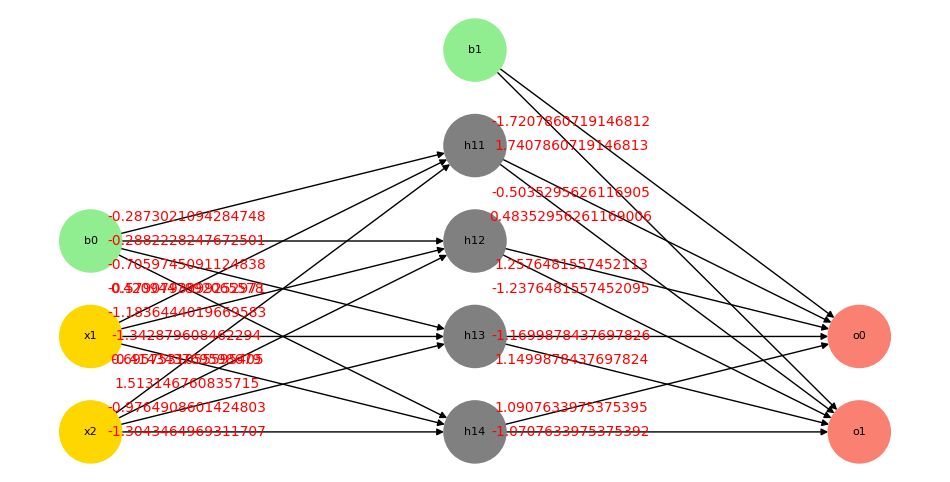

In [7]:
modelSoftmaxTwoLayer = ANN()
modelSoftmaxTwoLayer.load_model("softmax_two_layer")
modelSoftmaxTwoLayer.train(
    epoch=modelSoftmaxTwoLayer.learning_parameters["max_iteration"],
    learning_rate=modelSoftmaxTwoLayer.learning_parameters["learning_rate"],
    batch_size=modelSoftmaxTwoLayer.learning_parameters["batch_size"],
    error_threshold=modelSoftmaxTwoLayer.learning_parameters["error_threshold"],
)
modelSoftmaxTwoLayer.summarize(2)
modelSoftmaxTwoLayer.sse() 

EPOCH 1/1	|	Loss: 0.665	|	Time: 0.0 ms
SSE: 1.9451892438311082e-32


True

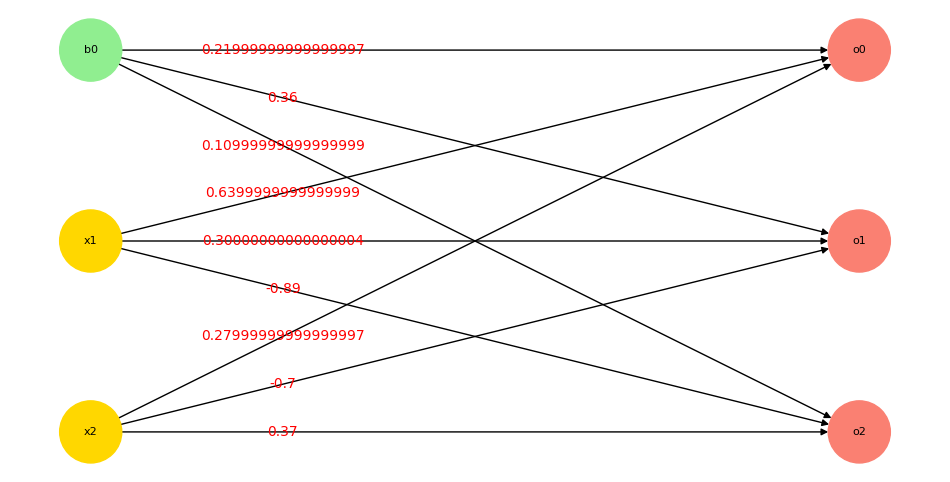

In [8]:
modelLinear = ANN()
modelLinear.load_model("linear")
modelLinear.train(
    epoch=modelLinear.learning_parameters["max_iteration"],
    learning_rate=modelLinear.learning_parameters["learning_rate"],
    batch_size=modelLinear.learning_parameters["batch_size"],
    error_threshold=modelLinear.learning_parameters["error_threshold"],
)
modelLinear.summarize(2)
modelLinear.sse()

EPOCH 1/1	|	Loss: 0.665	|	Time: 0.0 ms
SSE: 9.600000000000107e-07


True

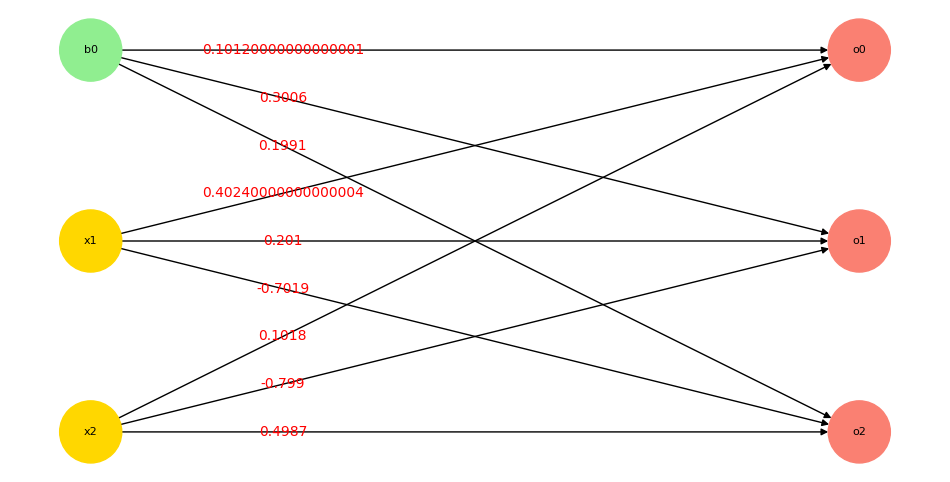

In [9]:
modelLinearSmallLR = ANN()
modelLinearSmallLR.load_model("linear_small_lr")
modelLinearSmallLR.train(
    epoch=modelLinearSmallLR.learning_parameters["max_iteration"],
    learning_rate=modelLinearSmallLR.learning_parameters["learning_rate"],
    batch_size=modelLinearSmallLR.learning_parameters["batch_size"],
    error_threshold=modelLinearSmallLR.learning_parameters["error_threshold"],
)
modelLinearSmallLR.summarize(2)
modelLinearSmallLR.sse()

EPOCH 1/2	|	Loss: 0.665	|	Time: 0.0 ms
EPOCH 2/2	|	Loss: 0.1818	|	Time: 0.0 ms
SSE: 1.6948183510607676e-32


True

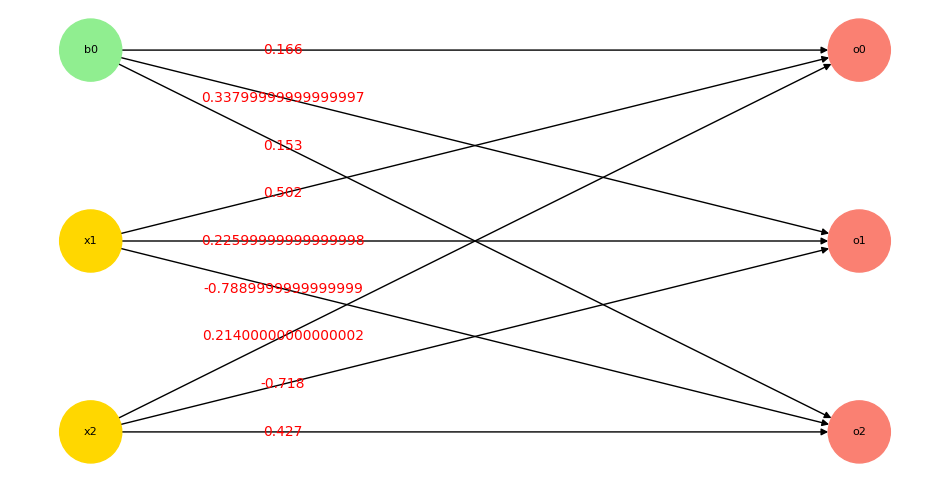

In [10]:
modelLinearTwoIter = ANN()
modelLinearTwoIter.load_model("linear_two_iteration")
modelLinearTwoIter.train(
    epoch=modelLinearTwoIter.learning_parameters["max_iteration"],
    learning_rate=modelLinearTwoIter.learning_parameters["learning_rate"],
    batch_size=modelLinearTwoIter.learning_parameters["batch_size"],
    error_threshold=modelLinearTwoIter.learning_parameters["error_threshold"],
)
modelLinearTwoIter.summarize(2)
modelLinearTwoIter.sse()

EPOCH 1/1	|	Loss: 0.677	|	Time: 0.0 ms
SSE: 1.0785207688568521e-32


True

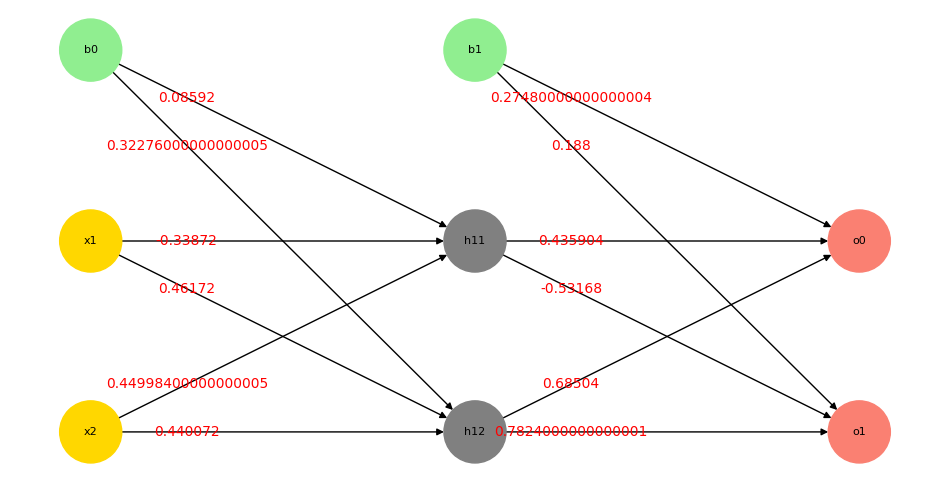

In [11]:
modelMLP = ANN()
modelMLP.load_model("mlp")
modelMLP.train(
    epoch=modelMLP.learning_parameters["max_iteration"],
    learning_rate=modelMLP.learning_parameters["learning_rate"],
    batch_size=modelMLP.learning_parameters["batch_size"],
    error_threshold=modelMLP.learning_parameters["error_threshold"],
)
modelMLP.summarize(2)
modelMLP.sse()

EPOCH 1/1	|	Loss: 2.7935	|	Time: 0.0 ms
SSE: 3.851859888774472e-33


True

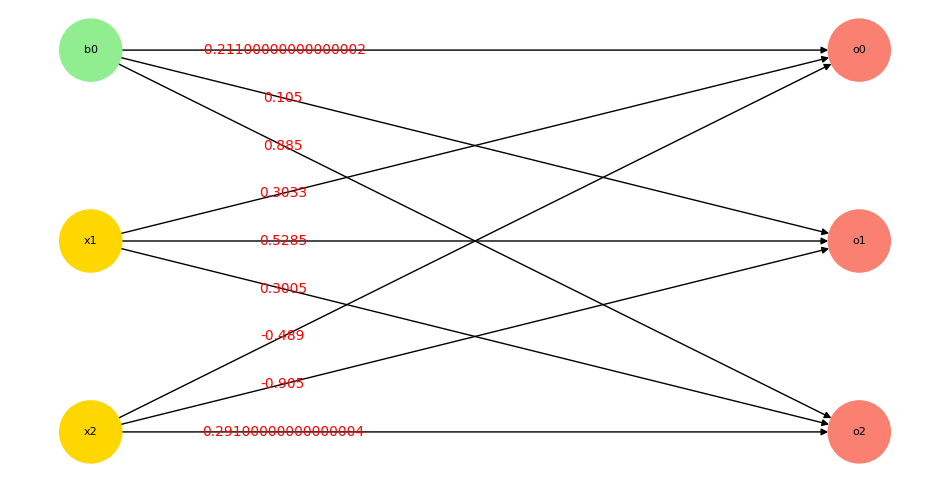

In [12]:
modelReluB = ANN()
modelReluB.load_model("relu_b")
modelReluB.train(
    epoch=modelReluB.learning_parameters["max_iteration"],
    learning_rate=modelReluB.learning_parameters["learning_rate"],
    batch_size=modelReluB.learning_parameters["batch_size"],
    error_threshold=modelReluB.learning_parameters["error_threshold"],
)
modelReluB.summarize(2)
modelReluB.sse()

EPOCH 1/10	|	Loss: 0.4728	|	Time: 1.0018 ms
EPOCH 2/10	|	Loss: 0.4708	|	Time: 0.0 ms
EPOCH 3/10	|	Loss: 0.4688	|	Time: 0.0 ms
EPOCH 4/10	|	Loss: 0.4668	|	Time: 0.0 ms
EPOCH 5/10	|	Loss: 0.4648	|	Time: 0.0 ms
EPOCH 6/10	|	Loss: 0.4628	|	Time: 0.9966 ms
EPOCH 7/10	|	Loss: 0.4609	|	Time: 0.0 ms
EPOCH 8/10	|	Loss: 0.4589	|	Time: 0.0 ms
EPOCH 9/10	|	Loss: 0.457	|	Time: 0.0 ms
EPOCH 10/10	|	Loss: 0.4551	|	Time: 0.0 ms
SSE: 2.0589774528721306e-08


True

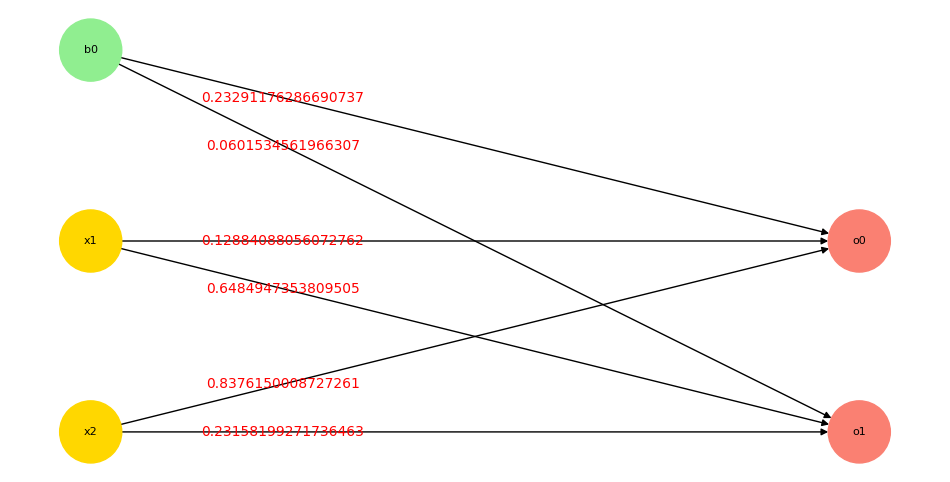

In [13]:
modelSigmoid = ANN()
modelSigmoid.load_model("sigmoid")
modelSigmoid.train(
    epoch=modelSigmoid.learning_parameters["max_iteration"],
    learning_rate=modelSigmoid.learning_parameters["learning_rate"],
    batch_size=modelSigmoid.learning_parameters["batch_size"],
    error_threshold=modelSigmoid.learning_parameters["error_threshold"],
)
modelSigmoid.summarize(2)
modelSigmoid.sse()

EPOCH 1/10	|	Loss: 2.7317	|	Time: 0.0 ms
EPOCH 2/10	|	Loss: 2.3896	|	Time: 0.0 ms
EPOCH 3/10	|	Loss: 2.0991	|	Time: 1.5068 ms
EPOCH 4/10	|	Loss: 1.8506	|	Time: 0.0 ms
EPOCH 5/10	|	Loss: 1.6332	|	Time: 0.0 ms
EPOCH 6/10	|	Loss: 1.4387	|	Time: 0.0 ms
EPOCH 7/10	|	Loss: 1.2621	|	Time: 0.0 ms
EPOCH 8/10	|	Loss: 1.101	|	Time: 0.0 ms
EPOCH 9/10	|	Loss: 0.9544	|	Time: 1.1604 ms
EPOCH 10/10	|	Loss: 0.8224	|	Time: 0.102 ms
SSE: 1.950457676824816e-16


True

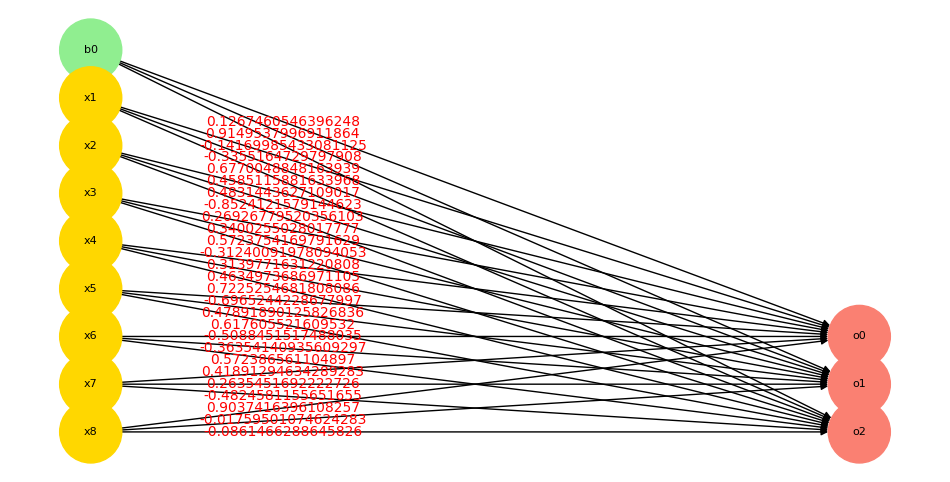

In [14]:
modelSoftmax = ANN()
modelSoftmax.load_model("softmax")
modelSoftmax.train(
    epoch=modelSoftmax.learning_parameters["max_iteration"],
    learning_rate=modelSoftmax.learning_parameters["learning_rate"],
    batch_size=modelSoftmax.learning_parameters["batch_size"],
    error_threshold=modelSoftmax.learning_parameters["error_threshold"],
)
modelSoftmax.summarize(2)
modelSoftmax.sse()

# Comparison with Keras

Digunakan test case softmax yang diberikan di pada kasus uji

In [15]:
kerasModelSoftmax = Sequential(
    [
        Input(shape=(8), name="inputs"),
        Dense(3, activation="softmax", name="dense_1", bias_initializer='ones'),
    ]
)

weights = np.array([[-0.2, 0.8, 0.2],
        [0.3, -0.7, 0.3],
        [0.4, 0.6, -0.4],
        [0.5, 0.5, 0.5],
        [-0.6, 0.4, 0.6],
        [-0.7, -0.3, 0.7],
        [0.8, 0.2, -0.8],
        [0.9, -0.1, 0.0]])
bias = np.array([0.1, 0.9, -0.1])

kerasModelSoftmax.layers[0].set_weights([weights, bias])

kerasModelSoftmax.compile(optimizer = tf.keras.optimizers.SGD(learning_rate=0.01), loss='categorical_crossentropy')

x = np.array([[-2.4, -2.78, -0.6, 0.37, 2.46, -0.92, 2.76, 2.62],
      [-1.79, 1.65, -0.77, -1.03, 0.1, 2.12, -2.36, 1.25],
      [1.65, 2.34, 0.27, 2.34, 0.52, 1.37, 1.77, 0.62]])

y = np.array([
            [0, 1, 0],
      [1, 0, 0],
      [0, 0, 1]
        ])
kerasModelSoftmax.fit(x, y, batch_size=1, epochs=10)
kerasModelSoftmax.layers[0].get_weights()


Epoch 1/10

3/3 [==============================] - 1s 5ms/step - loss: 2.7316
Epoch 2/10
3/3 [==============================] - 0s 3ms/step - loss: 2.3893
Epoch 3/10
3/3 [==============================] - 0s 3ms/step - loss: 2.0986
Epoch 4/10
3/3 [==============================] - 0s 2ms/step - loss: 1.8510
Epoch 5/10
3/3 [==============================] - 0s 3ms/step - loss: 1.6343
Epoch 6/10
3/3 [==============================] - 0s 2ms/step - loss: 1.4400
Epoch 7/10
3/3 [==============================] - 0s 3ms/step - loss: 1.2635
Epoch 8/10
3/3 [==============================] - 0s 2ms/step - loss: 1.1019
Epoch 9/10
3/3 [==============================] - 0s 2ms/step - loss: 0.9550
Epoch 10/10
3/3 [==============================] - 0s 3ms/step - loss: 0.8230


[array([[-0.33622304,  0.67743087,  0.45879218],
        [ 0.48232946, -0.85197866,  0.2696492 ],
        [ 0.33985272,  0.57249945, -0.31235218],
        [ 0.31397626,  0.46312973,  0.72289413],
        [-0.6958973 ,  0.47822642,  0.6176708 ],
        [-0.50913   , -0.3634721 ,  0.57260185],
        [ 0.4195559 ,  0.26263487, -0.48219103],
        [ 0.90441316, -0.01834314, -0.08607012]], dtype=float32),
 array([ 0.12697506,  0.9145769 , -0.14155218], dtype=float32)]

# Iris Prediction

## ANN from Scratch

EPOCH 1/200	|	Loss: 10.7801	|	Time: 14.1122 ms
EPOCH 2/200	|	Loss: 10.0619	|	Time: 11.7793 ms
EPOCH 3/200	|	Loss: 10.0103	|	Time: 11.3597 ms
EPOCH 4/200	|	Loss: 9.9476	|	Time: 9.8717 ms
EPOCH 5/200	|	Loss: 9.7906	|	Time: 10.0453 ms
EPOCH 6/200	|	Loss: 9.496	|	Time: 14.5233 ms
EPOCH 7/200	|	Loss: 9.2184	|	Time: 11.631 ms
EPOCH 8/200	|	Loss: 8.8929	|	Time: 8.1313 ms
EPOCH 9/200	|	Loss: 7.0837	|	Time: 11.003 ms
EPOCH 10/200	|	Loss: 6.2847	|	Time: 10.0381 ms
EPOCH 11/200	|	Loss: 5.8644	|	Time: 11.5745 ms
EPOCH 12/200	|	Loss: 5.6456	|	Time: 11.0476 ms
EPOCH 13/200	|	Loss: 5.5314	|	Time: 10.5231 ms
EPOCH 14/200	|	Loss: 6.3558	|	Time: 10.0253 ms
EPOCH 15/200	|	Loss: 11.5898	|	Time: 11.5893 ms
EPOCH 16/200	|	Loss: 10.4398	|	Time: 12.2197 ms
EPOCH 17/200	|	Loss: 8.8841	|	Time: 10.488 ms
EPOCH 18/200	|	Loss: 8.3696	|	Time: 11.9247 ms
EPOCH 19/200	|	Loss: 6.3588	|	Time: 13.0267 ms
EPOCH 20/200	|	Loss: 5.9859	|	Time: 10.0727 ms
EPOCH 21/200	|	Loss: 5.7479	|	Time: 13.5109 ms
EPOCH 22/200	|	Loss: 5.

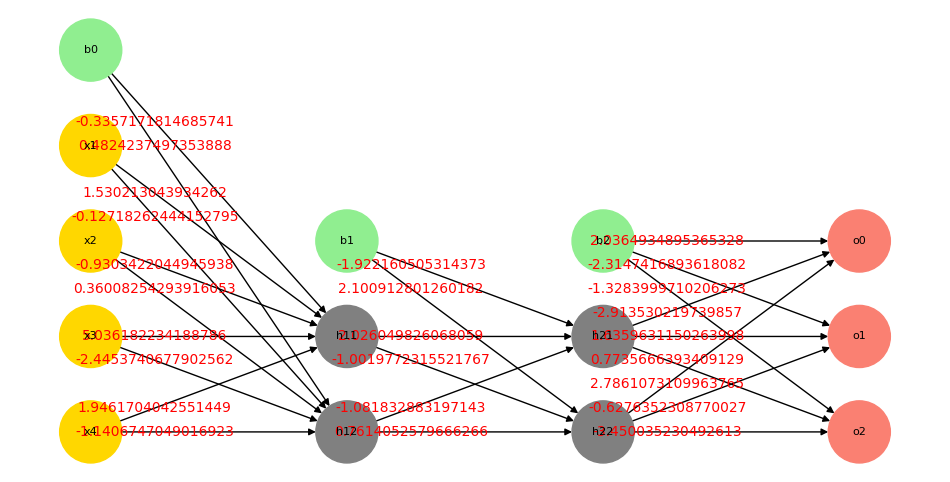

In [16]:
modelIris = ANN(
    [
        Layer('relu', 2, np.array([[0.459, 0.459], [0.068, -0.193], [0.244, -0.298], [-0.412, -0.22]]), np.array([-0.22, 0.445])),
        Layer('sigmoid', 2, np.array([[-0.059, -0.331], [-0.355, -0.195]]), np.array([-0.05, -0.09])),
        Layer('sigmoid', 3, np.array([[-0.391, -0.187, -0.173], [-0.221, 0.164, -0.395]]), np.array([0.165, 0.086, 0.461]))
    ]
)

modelIris.fit(X_train.to_numpy(), y_train)

modelIris.train(epoch=200, learning_rate=0.135, error_threshold = 0.01, batch_size=32)

modelIris.summarize(2)

In [17]:
pred = modelIris.predict(X_test)
pred

array([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2], dtype=int64)

In [18]:
accuracy_score(np.argmax(y_test, axis = 1), pred)

0.36666666666666664

## Using Keras

In [19]:
# Define layers
model = Sequential(
    [
        Input(shape=(4), name="inputs"),
        Dense(2, activation="relu"),
        Dense(2, activation="sigmoid"),
        Dense(3, activation="sigmoid"),
    ]
)

model.layers[0].set_weights([np.array([[0.459, 0.459], [0.068, -0.193], [0.244, -0.298], [-0.412, -0.22]]), np.array([-0.22, 0.445])])
model.layers[1].set_weights([np.array([[-0.059, -0.331], [-0.355, -0.195]]), np.array([-0.05, -0.09])])
model.layers[2].set_weights([np.array([[-0.391, -0.187, -0.173], [-0.221, 0.164, -0.395]]), np.array([0.165, 0.086, 0.461])])

# Compile the model
model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.135, name="sgd"), loss="mse", metrics=["accuracy"])

# Train
model.fit(X_train.to_numpy(), y_train, epochs=200, batch_size=32, verbose=0)

# Evaluate the model
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test Loss: {test_loss}\t|\tTest Accuracy: {test_accuracy}")

# Make predictions
y_pred = model.predict(X_test)
print(np.argmax(y_pred, axis=1))

print(
    classification_report(np.argmax(y_test, axis = 1), np.argmax(y_pred, axis=1), target_names=le.classes_)
)


1/1 [==============================] - 0s 151ms/step - loss: 0.2122 - accuracy: 0.9000
Test Loss: 0.2122352421283722	|	Test Accuracy: 0.8999999761581421
1/1 [==============================] - 0s 101ms/step
[1 0 2 1 2 0 1 2 1 1 1 0 0 0 0 1 2 1 1 2 0 1 0 2 2 2 2 2 0 0]
                 precision    recall  f1-score   support

    Iris-setosa       1.00      1.00      1.00        10
Iris-versicolor       0.80      0.89      0.84         9
 Iris-virginica       0.90      0.82      0.86        11

       accuracy                           0.90        30
      macro avg       0.90      0.90      0.90        30
   weighted avg       0.90      0.90      0.90        30



<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=18d33dcc-5cb2-491c-8f81-a8cc29872517' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>